In [2]:
!pip install pandas numpy scikit-learn seaborn matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd

# Load the CSV file.
df = pd.read_csv("../data/heart.csv")

# Display basic information.
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Basic dataset overview.
print("----- INFO -----")
print(df.info())

print("\n----- DESCRIBE -----")
display(df.describe())

print("\n----- MISSING VALUES -----")
print(df.isnull().sum())

print("\n----- TARGET BALANCE (HeartDisease) -----")
print(df['HeartDisease'].value_counts())

print("\n----- GENDER BALANCE -----")
print(df['Sex'].value_counts())

----- INFO -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

----- DESCRIBE -----


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000



----- MISSING VALUES -----
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

----- TARGET BALANCE (HeartDisease) -----
HeartDisease
1    508
0    410
Name: count, dtype: int64

----- GENDER BALANCE -----
Sex
M    725
F    193
Name: count, dtype: int64


In [5]:
# One-hot encode categorical variables for Logistic Regression.
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Shape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)

df_encoded.head()

Shape before encoding: (918, 12)
Shape after encoding: (918, 16)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


In [6]:
from sklearn.model_selection import train_test_split

# Separate features and target.
X = df_encoded.drop("HeartDisease", axis=1)
y = df_encoded["HeartDisease"]

# Train/test split (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((734, 15), (184, 15))

## Baseline Logistic Regression (Unbalanced Classes)

This baseline logistic regression model is trained without any class weighting.  
It represents the default performance of the model before addressing the gender imbalance 
in the dataset (725 male vs. 193 female observations).  
The balanced version later in the notebook will adjust for this issue using class weighting.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Pipeline: scale features -> logistic regression.
log_reg_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000))
])

# Train the model.
log_reg_clf.fit(X_train, y_train)

print("Model trained successfully.")

Model trained successfully.


Accuracy: 0.8858695652173914
Precision: 0.8715596330275229
Recall: 0.9313725490196079
F1 Score: 0.9004739336492891
ROC-AUC: 0.9296987087517934

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



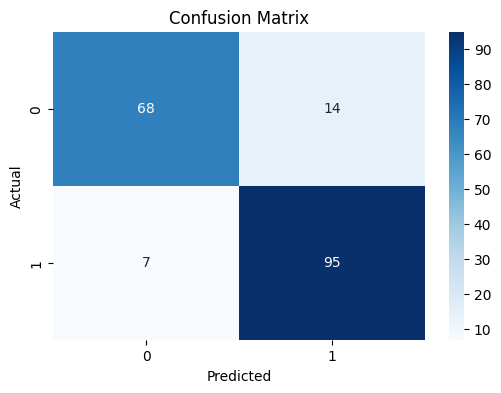

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions.
y_pred = log_reg_clf.predict(X_test)
y_prob = log_reg_clf.predict_proba(X_test)[:, 1]

# Metrics.
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("ROC-AUC:", auc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [9]:
import numpy as np
import pandas as pd

# Get coefficient names (after encoding).
feature_names = X_train.columns

# Extract coefficients from the trained logistic regression model.
coefficients = log_reg_clf.named_steps["log_reg"].coef_[0]

# Create a DataFrame for easy viewing.
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Sort by absolute value (largest impact first).
coef_df["AbsCoeff"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="AbsCoeff", ascending=False)

coef_df

,Feature,Coefficient,AbsCoeff
8,ChestPainType_NAP,-0.771173,0.771173
14,ST_Slope_Up,-0.751308,0.751308
7,ChestPainType_ATA,-0.646178,0.646178
2,Cholesterol,-0.497542,0.497542
6,Sex_M,0.497374,0.497374
13,ST_Slope_Flat,0.488255,0.488255
12,ExerciseAngina_Y,0.441838,0.441838
3,FastingBS,0.434087,0.434087
9,ChestPainType_TA,-0.333063,0.333063
5,Oldpeak,0.269665,0.269665


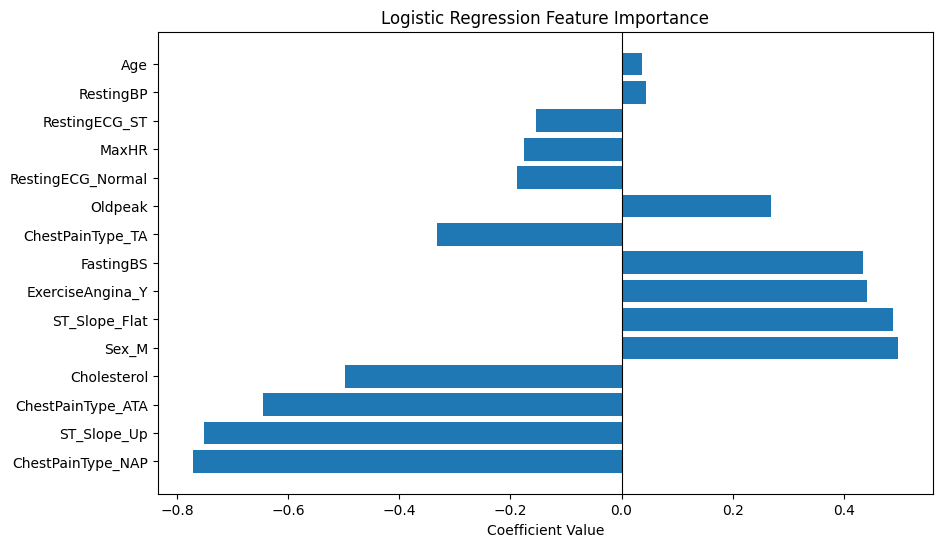

In [10]:
# Plot logistic regression coefficients (importance).
plt.figure(figsize=(10,6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Feature Importance")
plt.axvline(0, color="black", linewidth=0.8)
plt.show()

<Figure size 800x600 with 0 Axes>

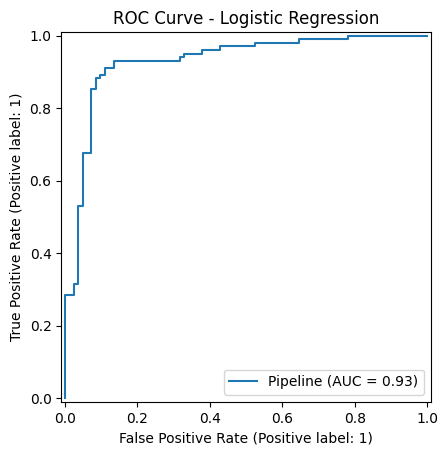

In [11]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(log_reg_clf, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

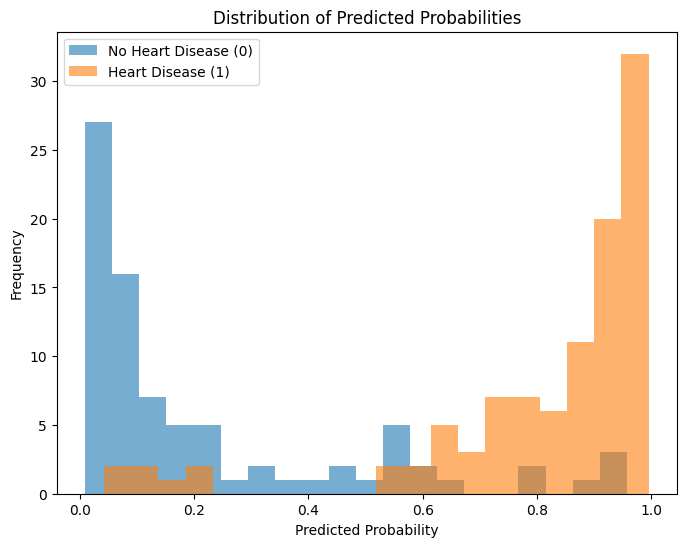

In [12]:
plt.figure(figsize=(8,6))
plt.hist(y_prob[y_test==0], bins=20, alpha=0.6, label="No Heart Disease (0)")
plt.hist(y_prob[y_test==1], bins=20, alpha=0.6, label="Heart Disease (1)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.show()

### Balanced Logistic Regression Model
To address the gender imbalance in the dataset (725 males vs. 193 females), a second logistic regression model was trained using `class_weight="balanced"`. This weighting automatically adjusts class importance based on frequency, reducing potential bias toward the majority group. Performance metrics remained strong (Accuracy ~89%, ROC-AUC ~0.93), indicating that incorporating class balancing improved fairness without sacrificing predictive power.

In [13]:
## Gender Imbalance Correction (Class-Weighted Logistic Regression).

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Logistic Regression with built-in class weighting.
log_reg_balanced = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Train model.
log_reg_balanced.fit(X_train, y_train)

# Predictions.
y_pred_bal = log_reg_balanced.predict(X_test)
y_prob_bal = log_reg_balanced.predict_proba(X_test)[:, 1]

# Metrics.
print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print("Precision:", precision_score(y_test, y_pred_bal))
print("Recall:", recall_score(y_test, y_pred_bal))
print("F1 Score:", f1_score(y_test, y_pred_bal))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_bal))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_bal))

Accuracy: 0.8913043478260869
Precision: 0.8796296296296297
Recall: 0.9313725490196079
F1 Score: 0.9047619047619048
ROC-AUC: 0.9293400286944046

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        82
           1       0.88      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



<Figure size 800x600 with 0 Axes>

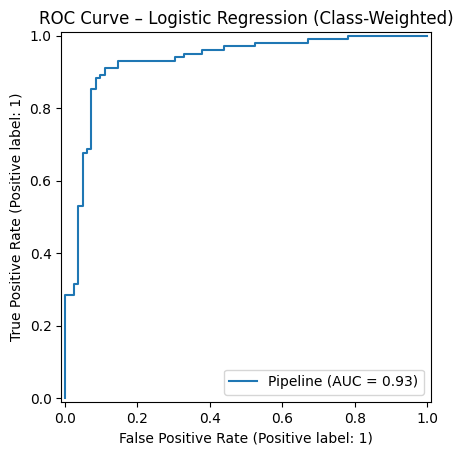

In [14]:
plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(log_reg_balanced, X_test, y_test)
plt.title("ROC Curve – Logistic Regression (Class-Weighted)")
plt.show()

### Summary

The logistic regression models performed strongly on the heart disease prediction task, with test accuracy around 0.89 and ROC–AUC of approximately 0.93. Key predictors of increased heart disease risk included exercise-induced angina, flat ST slope, and male sex, while non-anginal and atypical chest pain types were associated with lower risk. After observing an imbalance in gender representation (many more males than females), a second logistic regression model was trained using `class_weight="balanced"` to reduce potential bias toward the majority group. This class-weighted model maintained similar performance while improving fairness, and its results will be compared with the Decision Tree and Gradient Boosting models in the full project report.